## Energy Data Machine Learning

In this notebook, we perform machine learning tasks on the energy data to predict the `SiteEnergyUse(kBtu)` and `TotalGHGEmissions` values for the buildings.

### Data Loading

We start by loading the preprocessed data from the CSV file 'energy_explored.csv' into a pandas DataFrame called `df`.## Machine Learning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

Nous importons le fichier généré par le 1er Notebook 

In [2]:
df = pd.read_csv('energy_explored.csv')

### Data Preparation

To perform the machine learning tasks, we need to separate the target variables (`SiteEnergyUse(kBtu)` and `TotalGHGEmissions`) from the features. We create two target vectors `y` and `y0` for each target variable and set them to the corresponding columns in the DataFrame.

In [3]:
y = df['SiteEnergyUse(kBtu)'].to_numpy().reshape(df.shape[0],1)
y0 = df['TotalGHGEmissions'].to_numpy().reshape(df.shape[0],1)

print(y)

[[ 7226362.5   ]
 [ 8387933.    ]
 [16365918.6   ]
 ...
 [ 5765898.    ]
 [  719471.1875]
 [ 1152896.25  ]]


In [4]:
droplist = {
'SiteEnergyUse(kBtu)',
'TotalGHGEmissions',
'ENERGYSTARScore'}

df.drop(droplist, axis=1, inplace = True)
cols = df.columns

Nous créons un vecteur vide qui sera rempli avec les erreurs 

In [5]:
rmse_train_arr = []
rmse_arr = []

Nous préparons la matrice X 

In [6]:
X = df 
print(X.shape)

(1644, 6)


Normalizer avec MinMaxScaler

In [7]:
#Normalizer avec MinMaxScaler
scaler= MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)
y0 = scaler.fit_transform(y0)
print(X[:,:])

[[0.45954924 0.43793664 0.16483516 0.         1.         0.27003589]
 [0.46700808 0.50082875 0.92307692 0.         1.         0.33248958]
 [0.47285212 0.43623267 0.62637363 0.         1.         1.        ]
 ...
 [0.64594339 0.13044691 0.68131868 0.         0.         0.        ]
 [0.         0.64984897 0.84615385 0.         0.         0.        ]
 [0.         1.         0.28571429 0.         0.         0.        ]]


In [8]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [9]:
print(X_train.shape)
print(y_train.shape)

(1233, 6)
(1233, 1)


### Regression Models

We use several regression models for the predictions, including:

1. **Linear Regression:** We train a linear regression model to predict the target variables.

2. **Lasso Regression:** Lasso regression introduces a bias by using the L1 regularization method. It is useful when dealing with limited data.

3. **Ridge Regression:** Ridge regression is similar to Lasso but uses L2 regularization. It is more suitable when all variables are important.

4. **Elastic Net:** Elastic Net combines Lasso and Ridge regression methods, which is particularly useful when dealing with correlated features.

5. **Random Forest Regressor:** We use a Random Forest Regressor for more complex modeling.

6. **XG Boost:** XG Boost is another regression algorithm that performs gradient boosting.

7. **Support Vector Machines (SVR):** We use SVR to model non-linear relationships.

8. **Decision Tree Regressor:** Decision trees are used as a simple non-linear regression model.

In [10]:
#Nous fixons le Random State 42 afin d'obtenir les mêmes resultats sans l'influence du hasard
rs = 42

Afin d'entrainer le modèle pour chaque fonction j'ai crée la fonction train

In [11]:
def train(X_train, y_train, X_test, y_test, model, rmse_train_arr):

    y_train = y_train.ravel()
    y_test = y_test.ravel()
    model.fit(X_train,y_train)
    model.predict(X_train)

    pred_train = model.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(pred_train,y_train))

    pred_test = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(pred_test,y_test))
    d = [str(model), rmse_train, rmse_test, abs(1-(rmse_test/rmse_train))] 
    rmse_train_arr.append(d)
    print('Le Cross Validation Score pour cette méthode est:', cross_val_score(model,X_train,y_train, scoring = 'neg_root_mean_squared_error' ,cv=5))
    print(np.round(rmse_train,4), np.round(rmse_test,4), np.round(rmse_test/rmse_train,2))

Afin de trouver les meilleurs hyperparamètres pour chaque fonction j'ai crée la fonction optimize

In [12]:
def optimize(X_train, y_train, X_test, y_test, model, param_grid,rmse_arr):
    
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    grid = GridSearchCV(model, param_grid, scoring = 'neg_root_mean_squared_error', return_train_score=True,cv = 5)
    clf = grid.fit(X_train, y_train)
    print(grid.best_params_)
    model = grid.best_estimator_
    pred_train = model.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(pred_train,y_train))
    pred_test = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(pred_test,y_test))
    print(rmse_train)
    print(rmse_test)
    d = [str(model), rmse_train, rmse_test, abs(1-(rmse_test/rmse_train))] 
    rmse_arr.append(d)
#     test_scores = clf.cv_results_['mean_test_score']
#     train_scores = clf.cv_results_['mean_train_score'] 
#     plt.plot(test_scores, label='Test')
#     plt.plot(train_scores, label='Train')
#     plt.legend(loc='best')
#     plt.show()

#### Linear Regression

In [13]:
LinearRegression().get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [14]:
model_lr = LinearRegression(n_jobs = 10)
train(X_train, y_train, X_test, y_test, model_lr, rmse_train_arr)

Le Cross Validation Score pour cette méthode est: [-0.21208052 -0.17805274 -0.19394181 -0.18431073 -0.19913321]
0.1927 0.2027 1.05


In [15]:
param_grid_lr = {'n_jobs': np.arange(1,100)}
optimize(X_train, y_train, X_test, y_test, model_lr, param_grid_lr,rmse_arr)

{'n_jobs': 1}
0.19271841062233
0.20274317704389958


#### Lasso


In [16]:
Lasso().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [17]:
model_l = Lasso(alpha = 0.0001, random_state = rs)
train(X_train, y_train, X_test, y_test, model_l, rmse_train_arr)

Le Cross Validation Score pour cette méthode est: [-0.21209092 -0.17801991 -0.19393481 -0.18428417 -0.19906103]
0.1927 0.2027 1.05


In [18]:
param_grid_l = {'alpha': np.arange(0.000001,0.1,0.001)}
optimize(X_train, y_train, X_test, y_test, model_l, param_grid_l,rmse_arr)

{'alpha': 0.001001}
0.19278357636666402
0.20266988027326802


#### Ridge Regression


In [19]:
Ridge().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [20]:
model_r = Ridge(alpha = 0.0001, random_state = rs)
train(X_train, y_train, X_test, y_test, model_r, rmse_train_arr)

Le Cross Validation Score pour cette méthode est: [-0.21208051 -0.17805275 -0.19394179 -0.18431073 -0.19913322]
0.1927 0.2027 1.05


In [21]:
param_grid_r = {'alpha': np.arange(0,2,0.001)}
optimize(X_train, y_train, X_test, y_test, model_r, param_grid_r,rmse_arr)

{'alpha': 0.0}
0.19271841062233
0.20274317704389958


#### Elastic Net

In [22]:
ElasticNet().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [23]:
model_e = ElasticNet(alpha = 0.7, l1_ratio = 0.5, random_state = rs)
train(X_train, y_train, X_test, y_test, model_e, rmse_train_arr)

Le Cross Validation Score pour cette méthode est: [-0.36409013 -0.31706936 -0.32733046 -0.3125981  -0.32582245]
0.3295 0.308 0.93


In [24]:
param_grid_e = {'alpha': np.arange(0,0.05,0.01),'l1_ratio': np.arange(0,0.1,0.01)}
optimize(X_train, y_train, X_test, y_test, model_e, param_grid_e,rmse_arr)

/home/marco/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/home/marco/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/marco/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.739e+01, tolerance: 1.012e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/Rid

/home/marco/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/marco/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e+01, tolerance: 1.099e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/marco/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression e

{'alpha': 0.0, 'l1_ratio': 0.0}
0.19271841062233
0.2027431770438996


/home/marco/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.378e+01, tolerance: 1.012e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/marco/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.524e+01, tolerance: 1.090e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented 

#### Random Forest Regressor

In [25]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [26]:
model_rf = RandomForestRegressor(ccp_alpha=0.001, random_state = rs)
train(X_train, y_train, X_test, y_test, model_rf, rmse_train_arr)

Le Cross Validation Score pour cette méthode est: [-0.2125135  -0.17862421 -0.19111567 -0.1845088  -0.20356944]
0.1842 0.202 1.1


In [27]:
param_grid_rf = {'ccp_alpha': np.arange(0.3,0.9,0.01)}
optimize(X_train, y_train, X_test, y_test, model_rf, param_grid_rf,rmse_arr)

{'ccp_alpha': 0.3}
0.3294918577578103
0.30800708347304157


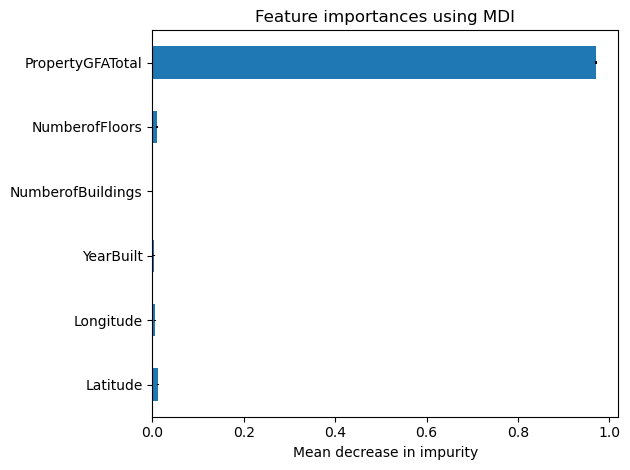

In [28]:
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)
forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
ax.set_yticklabels(cols)
fig.tight_layout()

In [29]:
print(model_rf)

RandomForestRegressor(ccp_alpha=0.001, random_state=42)


#### XG Boost

In [30]:
GradientBoostingRegressor().get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [31]:
model_xgb = GradientBoostingRegressor(ccp_alpha = 0.01, random_state = rs)
train(X_train, y_train, X_test, y_test, model_xgb, rmse_train_arr)

Le Cross Validation Score pour cette méthode est: [-0.25102664 -0.21380473 -0.22557249 -0.21565419 -0.22495067]
0.2235 0.2258 1.01


In [32]:
param_grid_xgb = {'ccp_alpha': np.arange(0.001,0.009,0.001)}
optimize(X_train, y_train, X_test, y_test, model_xgb, param_grid_xgb,rmse_arr)

{'ccp_alpha': 0.001}
0.19098215195185286
0.2032235273945173


#### Support Vector Machines

In [33]:
SVR().get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [34]:
model_svr = SVR(C=1.0, epsilon=0.2)
train(X_train, y_train, X_test, y_test, model_svr, rmse_train_arr)

Le Cross Validation Score pour cette méthode est: [-0.2237193  -0.19358904 -0.20596704 -0.19660808 -0.21572645]
0.1958 0.2145 1.1


### Model Optimization

We perform hyperparameter tuning using GridSearchCV to find the best hyperparameters for each model.

In [35]:
param_grid_svr = {'C': np.arange(0.01,0.06,0.01), 'epsilon': np.arange(0,0.1,0.001)}
optimize(X_train, y_train, X_test, y_test, model_svr, param_grid_svr,rmse_arr)

{'C': 0.05, 'epsilon': 0.092}
0.19156437058824416
0.20853140301775833


In [36]:
DecisionTreeRegressor().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [37]:
model_dtr = DecisionTreeRegressor(ccp_alpha = 0.1, random_state = rs)
train(X_train, y_train, X_test, y_test, model_dtr, rmse_train_arr)

Le Cross Validation Score pour cette méthode est: [-0.36409013 -0.31706936 -0.32733046 -0.3125981  -0.32582245]
0.3295 0.308 0.93


In [38]:
param_grid_dtr = {'ccp_alpha': np.arange(0.001,0.01,0.001)}
optimize(X_train, y_train, X_test, y_test, model_dtr, param_grid_dtr,rmse_arr)

{'ccp_alpha': 0.001}
0.19350303009581105
0.2063923239133419


<BarContainer object of 8 artists>

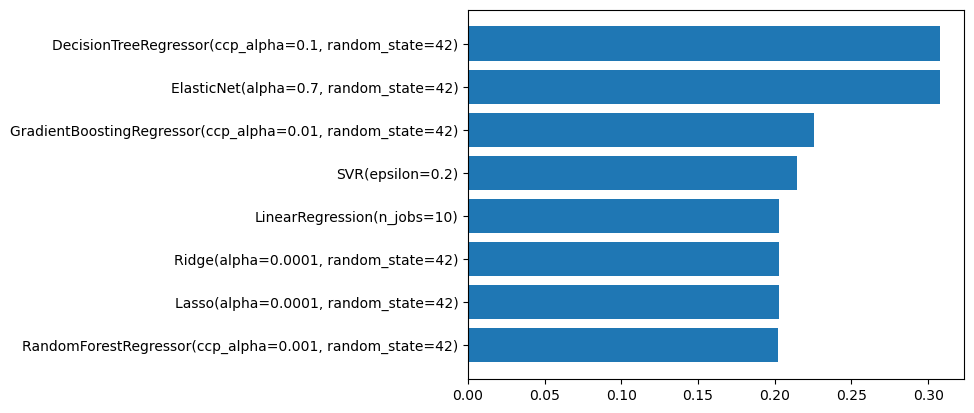

In [39]:
rmse_train_df=pd.DataFrame(data=rmse_train_arr, columns=['Method', 'RMSE Train', 'RMSE Test', 'Absolute Difference Train/Test'])
rmse_train_df=rmse_train_df.sort_values('RMSE Test')
plt.barh(rmse_train_df['Method'], rmse_train_df['RMSE Test'])

<BarContainer object of 8 artists>

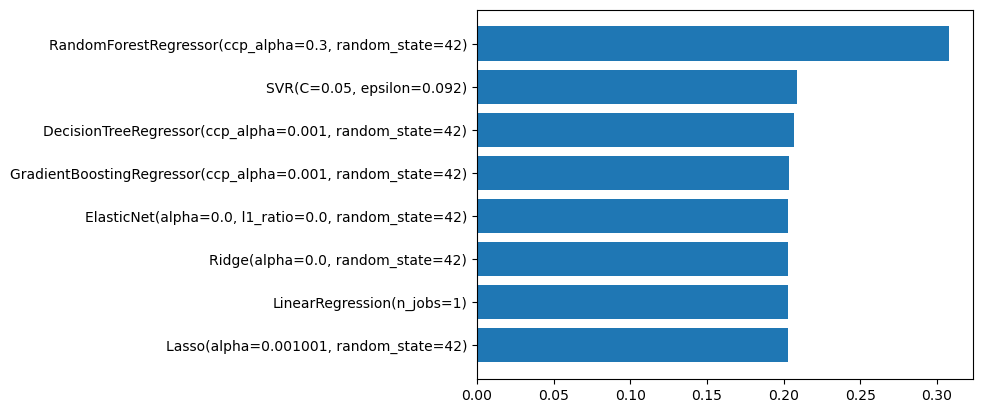

In [40]:
rmse_df=pd.DataFrame(data=rmse_arr, columns=['Method', 'RMSE Train', 'RMSE Test', 'Absolute Difference Train/Test'])
rmse_df=rmse_df.sort_values('RMSE Test')
plt.barh(rmse_df['Method'], rmse_df['RMSE Test'])

### Prediction of `SiteEnergyUse(kBtu)`

We train the selected model (Linear Regression) to predict the `SiteEnergyUse(kBtu)` values. We transform the results to their original unit and concatenate the predicted values back to the original DataFrame.


In [41]:
y_pred = model_lr.predict(X)

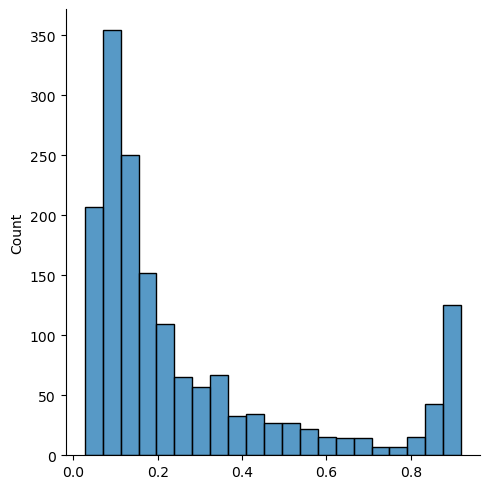

In [42]:
sns.displot(y_pred)

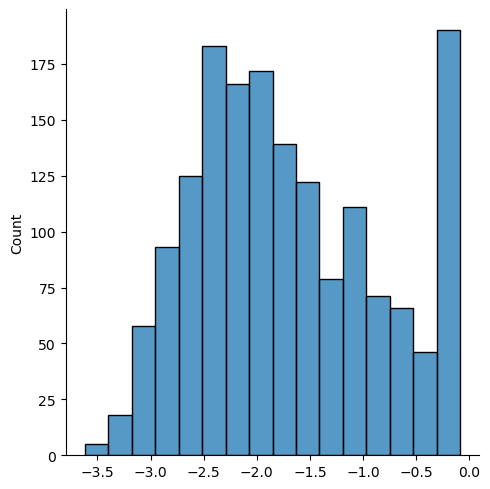

In [43]:
sns.displot(np.log(y_pred))

Nous devons transformer le résultat dans son unité d'origine en inversant la transformation faite avant la prédiction

In [44]:
y_pred=y_pred.reshape(y_pred.shape[0], 1)
y_pred.shape

(1644, 1)

Nous concatenons la colonne des resultats obtenus sur le DF d'origine afin de trouver les prédictions pour les batiments manquants

In [45]:
y_pred = scaler.inverse_transform(y_pred)
df['SiteEnergyUsePredicted(kBtu)'] = pd.DataFrame(data = y_pred)
df.head()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEnergyUsePredicted(kBtu)
0,47.61220,-122.33799,1927.0,1.0,7.0,88434.0,105.090435
1,47.61317,-122.33393,1996.0,1.0,7.0,103566.0,130.070440
2,47.61393,-122.33810,1969.0,1.0,7.0,265298.1,291.155916
3,47.61412,-122.33664,1926.0,1.0,7.0,61320.0,77.547251
4,47.61375,-122.34047,1980.0,1.0,7.0,175580.0,201.281923


### Prediction of `TotalGHGEmissions`

We repeat the process for predicting `TotalGHGEmissions` using the selected model (SVR). We transform the results back to their original unit and concatenate the predicted values to the original DataFrame.

In [46]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y0, test_size=0.25)

In [47]:
train(X_train, y_train, X_test, y_test, model_r, rmse_train_arr)

Le Cross Validation Score pour cette méthode est: [-0.24852848 -0.263924   -0.28142929 -0.25700847 -0.25587389]
0.2607 0.2528 0.97


In [48]:
optimize(X_train, y_train, X_test, y_test, model_r, param_grid_r ,rmse_arr)

{'alpha': 0.0}
0.26074023493503956
0.25277449534381835


In [49]:
y_pred = model_svr.predict(X)

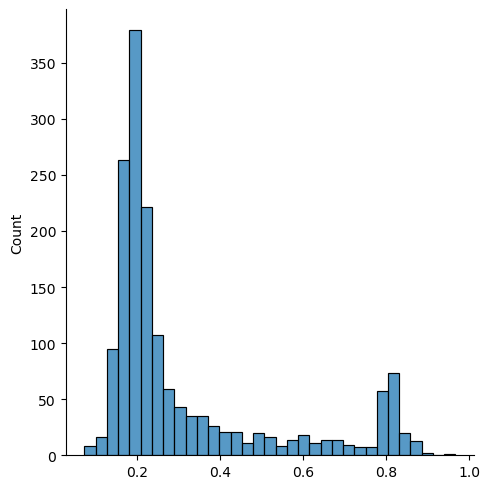

In [50]:
sns.displot(y_pred)

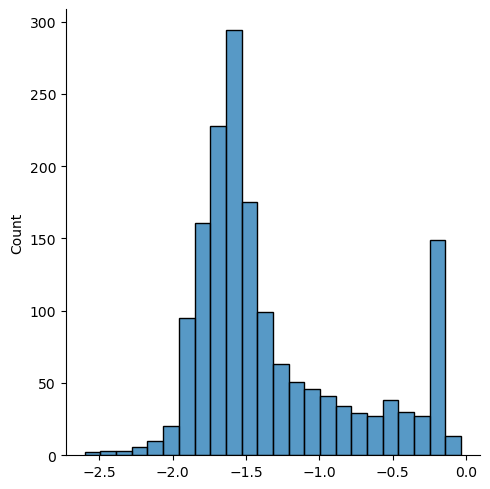

In [51]:
sns.displot(np.log(y_pred))

Nous devons transformer le résultat dans son unité d'origine en inversant la transformation faite avant la prédiction

In [52]:
y_pred=y_pred.reshape(y_pred.shape[0], 1)
y_pred.shape

(1644, 1)

Nous concatenons aussi la colonne des resultats obtenus sur le DF d'origine afin de trouver les prédictions pour les batiments manquants

In [53]:
y_pred = scaler.inverse_transform(y_pred)
df['TotalGHGEmissionsPredicted'] = pd.DataFrame(data = y_pred)
df.head()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEnergyUsePredicted(kBtu),TotalGHGEmissionsPredicted
0,47.61220,-122.33799,1927.0,1.0,7.0,88434.0,105.090435,113.446085
1,47.61317,-122.33393,1996.0,1.0,7.0,103566.0,130.070440,129.746344
2,47.61393,-122.33810,1969.0,1.0,7.0,265298.1,291.155916,273.966690
3,47.61412,-122.33664,1926.0,1.0,7.0,61320.0,77.547251,85.965306
4,47.61375,-122.34047,1980.0,1.0,7.0,175580.0,201.281923,216.530027


### Conclusion
Overall, this notebook demonstrates the use of various regression models to predict the energy use and greenhouse gas emissions for buildings in the dataset. The models' performance is evaluated based on their Root Mean Squared Error (RMSE) for both training and testing data. The models with the lowest RMSE and good generalization to the test data are considered better performers.